In [15]:
import time
import nrrd
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt

from dipy.tracking.local import LocalTracking, ThresholdTissueClassifier
from dipy.tracking.utils import random_seeds_from_mask
from dipy.reconst.dti import TensorModel
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
from dipy.data import fetch_stanford_hardi, read_stanford_hardi, get_sphere
from dipy.segment.mask import median_otsu
from dipy.viz import actor, window
from dipy.io.image import save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core import gradients
from dipy.tracking.streamline import Streamlines
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table, gradient_table_from_bvals_bvecs
from dipy.reconst.dti import fractional_anisotropy

from dipy.tracking import utils

**TODO** visualize streamlines of specific anatomic regions such as corpus callosum

In [ ]:
from dipy.tracking.local import LocalTracking
from dipy.viz import window, actor
from dipy.viz.colormap import line_colors
from dipy.tracking.streamline import Streamlines

def visStreamlines(streamlines):

    # Prepare the display objects.
    color = line_colors(streamlines)

    if window.have_vtk:
        streamlines_actor = actor.line(streamlines, line_colors(streamlines))

        # Create the 3D display.
        r = window.Renderer()
        r.add(streamlines_actor)
        window.record(r, n_frames=1, out_path='deterministic.png', size=(800, 800))
        window.show(r)
    else:
        print('we need VTK for proper visualisation of our fibres.')

# Data Handling

load bvec/bval and compute gradient table

In [3]:
bvals, bvecs = read_bvals_bvecs('bvals', 'bvecs')
gtab = gradient_table(bvals=bvals, bvecs=bvecs,b0_threshold=5)

In [4]:
gtab.info

B-values shape (288,)
         min 5.000000 
         max 3010.000000 
B-vectors shape (288, 3)
         min -0.999389 
         max 0.999012 


In [5]:
np.min(gtab.bvals)

5.0

In [6]:
img = nb.load('data.nii.gz')
dwi = img.get_data()

validate isotropic voxel size

In [7]:
img.header.get_zooms()[:3]

(1.25, 1.25, 1.25)

load binary brain segmentation

In [8]:
binarymask, options = nrrd.read('nodif_brain_mask.nrrd')

visualize DWI data

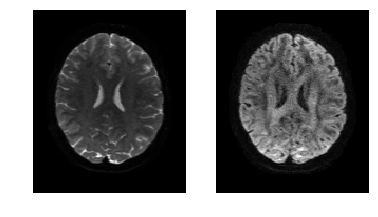

In [10]:
axial_middle = dwi.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(dwi[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(dwi[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()

# Brain Tissue Segmentation
**TODO**: check if datasets are registered

**TODO**: not working right yet

Segmentation of T1w data wrt. tissue state (cortico spinal fluid, gray- & white matter)

In [9]:
img = nb.load('T1w_acpc_dc_restore_1.25.nii.gz')
t1 = img.get_data()

In [11]:
from dipy.segment.tissue import TissueClassifierHMRF
nclass = 3
beta = 0.1 # smoothness regularizer
hmrf = TissueClassifierHMRF()
initial_segmentation, final_segmentation, PVE = hmrf.classify(t1, nclass, beta)

>> Iteration: 0
>> Iteration: 1
>> Iteration: 2
>> Iteration: 3
>> Iteration: 4
>> Iteration: 5
>> Iteration: 6
>> Iteration: 7
>> Iteration: 8
>> Iteration: 9
>> Iteration: 10
>> Iteration: 11
>> Iteration: 12
>> Iteration: 13
>> Iteration: 14
>> Iteration: 15
>> Iteration: 16
>> Iteration: 17
>> Iteration: 18
>> Iteration: 19
>> Iteration: 20
>> Iteration: 21
>> Iteration: 22
>> Iteration: 23
>> Iteration: 24
>> Iteration: 25
>> Iteration: 26
>> Iteration: 27
>> Iteration: 28
>> Iteration: 29
>> Iteration: 30
>> Iteration: 31
>> Iteration: 32
>> Iteration: 33
>> Iteration: 34
>> Iteration: 35
>> Iteration: 36
>> Iteration: 37
>> Iteration: 38
>> Iteration: 39
>> Iteration: 40
>> Iteration: 41
>> Iteration: 42
>> Iteration: 43
>> Iteration: 44
>> Iteration: 45
>> Iteration: 46
>> Iteration: 47
>> Iteration: 48
>> Iteration: 49
>> Iteration: 50
>> Iteration: 51
>> Iteration: 52
>> Iteration: 53
>> Iteration: 54
>> Iteration: 55
>> Iteration: 56
>> Iteration: 57
>> Iteration: 58
>> Iter

Visualize segmentation results

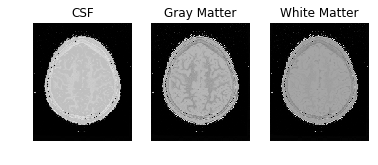

In [12]:
fig = plt.figure()
a = fig.add_subplot(1, 3, 1)
img_ax = np.rot90(PVE[..., 89, 0])
imgplot = plt.imshow(img_ax, cmap="gray")
a.axis('off')
a.set_title('CSF')
a = fig.add_subplot(1, 3, 2)
img_cor = np.rot90(PVE[:, :, 89, 1])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('Gray Matter')
a = fig.add_subplot(1, 3, 3)
img_cor = np.rot90(PVE[:, :, 89, 2])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('White Matter')
plt.savefig('probabilities.png', bbox_inches='tight', pad_inches=0)
plt.show()

# Tractography

In this section we'll generate streamlines using different approaches. This is gonna be the foundation for the evaluation of our method. We'll also employ simulated as well as curated data for our analysis.

## Diffusion Tensor Imaging

compute fractional anisotropy and select seeds_count seeds per voxel with FA > 0.3

In [13]:
import dipy.reconst.dti as dti
dti_wls = dti.TensorModel(gtab)
# roi_idx = (slice(20, 50), slice(55, 85), slice(38, 39)) #  splenium of the corpus callosum
fit_wls = dti_wls.fit(dwi)

NameError: name 'sphere' is not defined

generate seeds at each voxel for tracking

In [91]:
FA = fit_wls.fa
seeds = random_seeds_from_mask(FA > 0.3, seeds_count=1)

In [102]:
seeds.shape

(224258, 3)

In [ ]:
sphere = get_sphere('symmetric724')
start_time = time.time()
dtipeaks = peaks_from_model(model=dti_wls,
                            data=dwi,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False)
runtime = time.time() - start_time

In [ ]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
streamlines_generator = LocalTracking(csapeaks, classifier, seeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)
vizStreamlines(streamlines)

## Q-ball Reconstruction

In [75]:
csamodel = CsaOdfModel(gtab, 4)

In [76]:
sphere = get_sphere('symmetric724')
start_time = time.time()
csapeaks = peaks_from_model(model=csamodel,
                            data=dwi,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False)

GFA = csapeaks.gfa
runtime = time.time() - start_time
print('Runtime %.2f s / GFA.shape (%d, %d, %d)' % runtime % GFA.shape)

GFA.shape (108, 130, 109)


tracking

In [92]:
classifier = ThresholdTissueClassifier(csapeaks.gfa, .25)
streamlines_generator = LocalTracking(csapeaks, classifier, seeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)

In [107]:
len(seeds)

224258

compute number of points for each streamline

In [110]:
n_pts = [len(streamline) for streamline in bundle]

array([[  5.66720167,  63.52898406,  36.88718925],
       [  6.0439689 ,  63.21255917,  36.97619345],
       [  6.42073613,  62.89613429,  37.06519766],
       [  6.82729867,  62.61580011,  37.1434258 ],
       [  7.26022602,  62.37294896,  37.20340274],
       [  7.71968001,  62.18331392,  37.25762983],
       [  8.19500251,  62.0378982 ,  37.31169269]])

Visualisation

In [ ]:
from dipy.tracking.local import LocalTracking
from dipy.viz import window, actor
from dipy.viz.colormap import line_colors
from dipy.tracking.streamline import Streamlines

# Prepare the display objects.
color = line_colors(streamlines)

if window.have_vtk:
    streamlines_actor = actor.line(streamlines, line_colors(streamlines))

    # Create the 3D display.
    r = window.Renderer()
    r.add(streamlines_actor)
    # Save still images for this static example. Or for interactivity use
    window.record(r, n_frames=1, out_path='deterministic.png', size=(800, 800))
    window.show(r)

c:\users\user\anaconda3\envs\dti\lib\site-packages\dipy\viz\colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


## Constrained Spherical Deconvolution

In [97]:
response, ratio = auto_response(gtab, dwi, roi_radius=10, fa_thr=0.5)
print(response)
print(ratio)

(array([ 0.00123238,  0.00030619,  0.00030619]), 3265.4858)
0.248451359789


In [98]:
csd_model = ConstrainedSphericalDeconvModel(gtab, response)

In [103]:
sphere = get_sphere('symmetric724')

csd_peaks = peaks_from_model(model=csd_model,
                             data=dwi,
                             sphere=sphere,
                             mask=binarymask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)

In [ ]:
ren = window.Renderer()
ren.add(actor.peak_slicer(csd_peaks.peak_dirs,
                          csd_peaks.peak_values,
                          colors=None))

window.show(ren, size=(900, 900))

## Anatomically curated white matter atlas

**TODO** load atlas ORG-800FC-100HCP 

**TODO** apply atlas based tractography approach of Lauren

# Evaluate streamlines

In [ ]:
from dipy.tracking.utils import length # compute length of each streamline in mm

metrics: average lengths, touches gray matter, ...

# Generate Training data

dataset: (current Position, last direction, local DWI data) -> new direction

**TODO**: implement generation of training data given DWI & streamline dataset

**TODO** generate synthetic training data